## Simple Diffusion model

In [9]:
# imports
import jax
from flax import nnx
import optax
import jax.numpy as jnp
import dataclasses

from typing import List, Dict, Tuple

In [10]:
jax.devices()

[CudaDevice(id=0)]

In [25]:
%%bash 
nvidia-smi

Mon Jan  6 15:13:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  |   00000000:01:00.0 Off |                  N/A |
| 28%   23C    P8              8W /  250W |    8547MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Configuration

In [31]:
@dataclasses.dataclass
class Config:
    # Model architecture
    n_layers:int =8
    internal_dim:int = 512
    kernel_size: Tuple[int, int] = (3,3)
    

    # Image parameters
    image_size:int = 32
    num_channels:int = 3
    
    # Training parameters
    batch_size:int =32
    dataset_name:str ="uoft-cs/cifar10"

In [32]:
rngs = nnx.Rngs(0)
config = Config()

## Model

In [33]:
class ConvBlock(nnx.Module):
    def __init__(self, config: Config, rngs: nnx.Rngs):
        super().__init__()
        self.config = config
        self.conv = nnx.Conv(in_features=self.config.internal_dim, out_features=self.config.internal_dim, kernel_size=self.config.kernel_size, padding="SAME", rngs=rngs)
    def __call__(self, in_data: jax.Array) -> jax.Array:
        x = self.conv(in_data)
        x = jax.nn.selu(x)
        return x + in_data

In [ ]:
x = jax.random.normal(jax.random.key(0), (config.image_size, config.image_size, config.internal_dim))
cb = ConvBlock(config, rngs)
x, cb(x)

In [34]:
class DenoizingModel(nnx.Module):
    def __init__(self, config: Config, rngs: nnx.Rngs):
        super().__init__()
        self.config = config
        self.in_conv = nnx.Conv(in_features=self.config.num_channels, out_features=self.config.internal_dim, kernel_size=self.config.kernel_size, padding="SAME", rngs=rngs)
        self.out_conv = nnx.Conv(in_features=self.config.internal_dim, out_features=self.config.num_channels, kernel_size=self.config.kernel_size, padding="SAME", rngs=rngs)
        self.stack = [ConvBlock(config, rngs) for _ in range(self.config.n_layers)]
    def __call__(self, in_data: jax.Array) ->jax.Array:
        x = self.in_conv(in_data)
        for lv in self.stack:
            x = lv(x)
        x = self.out_conv(x)
        return x
        

In [35]:
x = jax.random.normal(jax.random.key(0), (config.image_size, config.image_size, config.num_channels))
dm = DenoizingModel(config, rngs)
x.shape, dm(x).shape

((32, 32, 3), (32, 32, 3))

## Dataset

In [36]:
import datasets
from PIL import Image
from IPython.display import display

In [37]:
dataset=datasets.load_dataset(config.dataset_name, streaming=True)
dataset

README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

IterableDatasetDict({
    train: IterableDataset({
        features: ['img', 'label'],
        num_shards: 1
    })
    test: IterableDataset({
        features: ['img', 'label'],
        num_shards: 1
    })
})

In [38]:
def whitenen(img: jax.Array) -> jax.Array:
    assert img.dtype == jnp.uint8
    return (img.astype(jnp.float32)-128+31)/128

def dewhitenen(img: jax.Array) -> jax.Array:
    assert img.dtype == jnp.float32
    return (128.*img +128-31).astype(jnp.uint8)

In [42]:
batched_data =  dataset['train'].batch(config.batch_size, drop_last_batch=True).map(lambda x: {"x": jnp.array([jnp.array(i) for i in x["img"]])}, remove_columns=dataset["train"].column_names, batched=True, batch_size=32)

In [43]:
whtn_batched_data = batched_data.map(lambda x: {'x': whitenen(x['x'])})

In [44]:
for i in whtn_batched_data:
    wimage = i['x']
    break

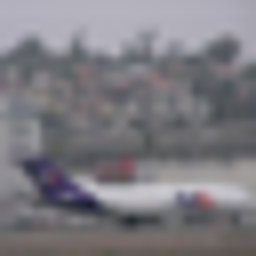

In [46]:
Image.frombytes('RGB', data=dewhitenen(wimage).tobytes(), size=(config.image_size, config.image_size)).resize((256, 256))

## Training